# Отток клиентов

Из банка стали уходить клиенты. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Необходимо создать модель и спрогнозировать, уйдёт клиент из банка в ближайшее время или нет.  
В наличии исторические данные о поведении клиентов и расторжении договоров с банком. 

# Описание данных

* RowNumber — индекс строки в данных
* CustomerId — уникальный идентификатор клиента
* Surname — фамилия
* CreditScore — кредитный рейтинг
* Geography — страна проживания
* Gender — пол
* Age — возраст
* Tenure — количество недвижимости у клиента
* Balance — баланс на счёте
* NumOfProducts — количество продуктов банка, используемых клиентом
* HasCrCard — наличие кредитной карты
* IsActiveMember — активность клиента
* EstimatedSalary — предполагаемая зарплата  

Целевой признак
* Exited — факт ухода клиента

## План работы с проектом

1. Откроем файл с данными, изучим его и подготовим данные к анализу; 
2. Исследуем баланс классов, обучим модель без учёта дисбаланса;
3. Улучшим качество модели, учитывая дисбаланс классов. Обучим разные модели и найдем лучшую;
4. Проведем финальное тестирование;
5. Проверим модели на вменяемость. 

***
# 1. Подготовка данных

Для подготовки данных нам необходимо выполнить следующие шаги:  
* Предобработать данные, заполнить пропуски, привести данные к нужным форматам;
* Преобразовать категориальные признаки в численные;
* Масштабировать количественные признаки.

***
## Предобработка данных

*Откроем файл и посмотрим на его структуру, данные и наличие или отсутсвие пропусков.*

In [1]:
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, roc_auc_score 
from sklearn.utils import shuffle
    
data = pd.read_csv('/datasets/Churn.csv')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Всего в файле 10000 объектов, дубликатов нет, пропуски есть в столбце Tenure.  
Все данные, кроме столбца Tenure приведены к нужному формату. Наименования столбцов нужно будет привести к нижнему регистру.  
Целевым признаком является столбец Exited.

*Приведем названия столбцов к нижнему регистру.*

In [2]:
new_names = data.columns.str.lower()
data.set_axis(new_names, axis = 'columns', inplace = True)
data.columns

Index(['rownumber', 'customerid', 'surname', 'creditscore', 'geography',
       'gender', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard',
       'isactivemember', 'estimatedsalary', 'exited'],
      dtype='object')

*Проверим таблицу на наличие пропусков и посмотрим сколько пропусков в процентном соотношении в каждом столбце*

In [3]:
(data.isnull().sum()/data.shape[0]*100).sort_values(ascending = False)

tenure             9.09
exited             0.00
estimatedsalary    0.00
isactivemember     0.00
hascrcard          0.00
numofproducts      0.00
balance            0.00
age                0.00
gender             0.00
geography          0.00
creditscore        0.00
surname            0.00
customerid         0.00
rownumber          0.00
dtype: float64

Видим, что 9% пропусков есть в столбце Tenure (количество недвижимости у клиента).   
Посмотрим распределение значений в этом столбце и подсчитаем количество каждого значения.

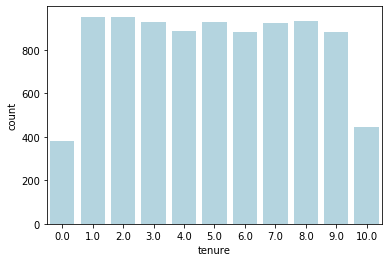

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
NaN     909
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: tenure, dtype: int64

In [4]:
sns.countplot(x='tenure', data=data, color='lightblue')
plt.show()
data.tenure.value_counts(dropna=False)

Количество объектов недвижимости у клиентов от 0 до 10, меньше всего клиентов без недвижимости и с десятью объектами.
Видим, что пропусков 909 - предположим, что пропуски появились из-за того, что клиенты без недвижимости оставляли это поле пустым.  

Заполним пропуски значением 0.

In [5]:
data.tenure = data.tenure.fillna(0)

Посмотрим после этого на распределение значений этого столбца.

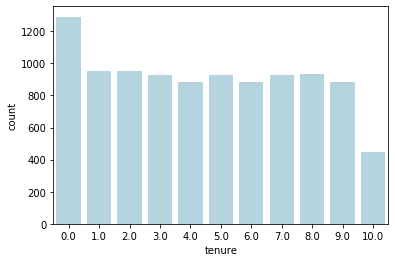

In [6]:
sns.countplot(x='tenure', data=data, color='lightblue')
plt.show()

Ситуация стала выглядеть более логично - количество клиентов без недвижимости стало немного больше, чем остальных вариантов.

*Изменим тип данных столбца tenure на целочисленый*

In [7]:
data.tenure = data.tenure.astype(int)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
rownumber          10000 non-null int64
customerid         10000 non-null int64
surname            10000 non-null object
creditscore        10000 non-null int64
geography          10000 non-null object
gender             10000 non-null object
age                10000 non-null int64
tenure             10000 non-null int64
balance            10000 non-null float64
numofproducts      10000 non-null int64
hascrcard          10000 non-null int64
isactivemember     10000 non-null int64
estimatedsalary    10000 non-null float64
exited             10000 non-null int64
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


*Проверим таблицу на наличие дубликатов*

In [8]:
data.duplicated().sum()

0

Дубликатов нет.

***
### Вывод

Каждый объект в наборе данных — это информация о одном из клиентов банка.

В файле 14 столбцов:

* RowNumber — индекс строки в данных
* CustomerId — уникальный идентификатор клиента
* Surname — фамилия
* CreditScore — кредитный рейтинг
* Geography — страна проживания
* Gender — пол
* Age — возраст
* Tenure — количество недвижимости у клиента
* Balance — баланс на счёте
* NumOfProducts — количество продуктов банка, используемых клиентом
* HasCrCard — наличие кредитной карты
* IsActiveMember — активность клиента
* EstimatedSalary — предполагаемая зарплата
* Exited — факт ухода клиента  

Целевым признаком является столбец Exited.  


На данном шаге были изучены имеющиеся данные, заполнены пропуски, изменен тип данных там, где это было нужно. 

***
## Преобразование категориальных признаков в численные

Для обучения наших будущих моделей нам необходимо преобразовать столбцы с категориальными данными в количественные.  
В нашей базе данных три столбца с категориальными данными - Surname, Geography, Gender.  

Для прогнозирования, уйдёт клиент из банка в ближайшее время или нет, нам не нужна информация о фамилии клиента, поэтому удалим столбец с данной информацией.

In [9]:
data = data.drop(['surname'], axis=1)
data.head()

,rownumber,customerid,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,1,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Теперь проведем преобразование категориальных признаков в численные методом *One-Hot Encoding*, который является более универсальным, чем метод *Ordinal Encoding*

In [10]:
data_new = pd.get_dummies(data, drop_first=True)
data_new.head()

,rownumber,customerid,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,geography_Germany,geography_Spain,gender_Male
0,1,15634602,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,2,15647311,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,3,15619304,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,4,15701354,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,5,15737888,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


### Вывод

На данном шаге было проведено преобразование категориальных признаков в численные методом One-Hot Encoding.  
Предварительно перед этим был удален столбец surname с информацией о фамилии клиента.

## Комментарий наставника
<span style="color:green">Всё верно.</span>

В таблице осталось два столбца, которые не нужны для обучения обучения модели.  
Это столбцы - rownumber и customerid. Удалим их.

In [11]:
data_new = data_new.drop(['rownumber', 'customerid'], axis=1)
data_new.head()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


***
## Масштабирование количественных признаков

Теперь проведем масштабирование данных в оставшихся численных столбцах, не трогая целевой столбец exited.  
Перед проведением масштабирования разделим данные на три выборки - обучающую, валидационную, тестовую в соотношении 3/1/1.

In [12]:
features = data_new.drop('exited', axis=1)
target = data_new['exited']

features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.4, random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, test_size=0.5, random_state=12345)

print('Размер обучающей выборки:', features_train.shape)
print('Размер валидационной выборки:', features_valid.shape)
print('Размер тестовой выборки:', features_test.shape)

Размер обучающей выборки: (6000, 11)
Размер валидационной выборки: (2000, 11)
Размер тестовой выборки: (2000, 11)


In [13]:
numeric = ['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard', 'isactivemember', 'estimatedsalary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

features_train.head()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,geography_Germany,geography_Spain,gender_Male
7479,-0.886751,-0.373192,1.104696,1.232271,-0.891560,0.642466,-1.055187,-0.187705,0,1,1
3411,0.608663,-0.183385,1.104696,0.600563,-0.891560,-1.556504,-1.055187,-0.333945,0,0,0
6027,2.052152,0.480939,-0.503694,1.027098,0.830152,-1.556504,0.947699,1.503095,1,0,1
1247,-1.457915,-1.417129,0.461340,-1.233163,0.830152,0.642466,-1.055187,-1.071061,0,0,1
3716,0.130961,-1.132419,-0.825373,1.140475,-0.891560,-1.556504,-1.055187,1.524268,1,0,0


***
### Вывод

На данном шаге было разделение данных на 3 выборки и проведено масштабирование численных признаков.  
Предварительно перед этим были удалены столбцы rownumber и customerid с информацией о номере записи и id клиента.

***
# 2. Исследование задачи

На данном этапе исследования необходимо выполнить следующие шаги:  
* Изучить баланс классов;  
* Обучить модель без учета дисбаланса

***
### Изучим баланс классов

Для получения наилучших результатов прогнозирования классы в данных должны быть сбалансированы.  
Посмотрим на их текущее состояние.

In [14]:
data_new.exited.value_counts(normalize=True)

0    0.7963
1    0.2037
Name: exited, dtype: float64

Видим, что классы не сбалансированы.  

***
### Обучение модели без учета дисбаланса

Посмотрим, какого результата прогнозирования можно достичь при работе с имеющимися данными без учета дисбаланса.

**Обучение модели**

В данном проекте нам предстоит решить модель бинарной классификации - обучить модель предсказывать уйдет ли клиент из банка или нет.  
На имеющихся данных построим модель Случайный лес и оценим её качество.

In [15]:
forest_unb = RandomForestClassifier(random_state=12345)
forest_unb.fit(features_train, target_train)
predictions_valid = forest_unb.predict(features_valid)
probabilities_valid = forest_unb.predict_proba(features_valid)
print('accuracy_score = {:.2f}'.format(accuracy_score(target_valid, predictions_valid)))
print('f1 = {:.2f}'.format(f1_score(target_valid, predictions_valid)))
print('AUC-ROC = {:.2f}'.format(roc_auc_score(target_valid, probabilities_valid[:,1])))

accuracy_score = 0.85
f1 = 0.56
AUC-ROC = 0.81


***
### Вывод

На данном этапе исследования мы изучили баланс классов в имеющейся выборке и провели обучение модели Случайный лес.  
Результаты работы модели следующие:  
* accuracy_score = 0.85
* f1 = 0.56
* AUC-ROC = 0.81

Значения метрик accuracy_score и AUC-ROC достаточно неплохие, но метрика f1-мера ниже целевого показателя.  
На следующем этапе работы посмотрим, можно ли улучшить результаты работы моделей.

***
# 3. Борьба с дисбалансом

Для того, чтобы улучшить работу нашей модели необходимо сбалансировать данные.  
Это можно сделать следующими способами:  
* Придать объектам редкого класса больший вес в параметрах модели;
* Увеличить выборку путем повторения несколько раз положительных объектов и проверить работу разных моделей;
* Уменьшить выборку путем уменьшения количества отрицательных объектов и проверить работу разных моделей;
* Нахождение оптимальных гиперпараметров наилучшей модели.

### Увеличение веса объектов редкого класса  в параметрах модели

Самым простым способом улучшения баланса классов является увеличение их веса в параметрах модели.  
Проверим, насколько это поможет улучшить нашу модель случайного леса, обученную ранее.

In [16]:
forest_b = RandomForestClassifier(random_state=12345, class_weight='balanced')
forest_b.fit(features_train, target_train)
predictions_valid = forest_b.predict(features_valid)
probabilities_valid = forest_b.predict_proba(features_valid)
print('accuracy_score = {:.2f}'.format(accuracy_score(target_valid, predictions_valid)))
print('f1 = {:.2f}'.format(f1_score(target_valid, predictions_valid)))
print('AUC-ROC = {:.2f}'.format(roc_auc_score(target_valid, probabilities_valid[:,1])))

accuracy_score = 0.85
f1 = 0.53
AUC-ROC = 0.81


Значения метрик accuracy_score и AUC-ROC не изменились, а значение метрики f1-мера снизилось.  
Данный метод балансировки классов нам не помог.  
Далее попробуем изменить баланс классов в выборке с помощью методов upsampling И downsampling. 

### Увеличение выборки путем повторения несколько раз положительных объектов (upsampling)

Техника увеличения выборки путем повторения несколько раз положительных объектов называется upsampling.  
Преобразование проходит в несколько этапов:
* Разделить обучающую выборку на отрицательные и положительные объекты;
* Скопировать несколько раз положительные объекты.  
В нашем случае увеличиваем выборку положительных объектов в 4 раза;
* С учётом полученных данных создать новую обучающую выборку;
* Перемешать данные.

In [17]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

Посмотрим размеры новых таблиц и изучим новый баланс классов.

In [18]:
print('Размеры таблицы features_upsampled:', features_upsampled.shape)
print('Размеры таблицы target_upsampled:',target_upsampled.shape)
print()
print(target_upsampled.value_counts(normalize=True))

Размеры таблицы features_upsampled: (9588, 11)
Размеры таблицы target_upsampled: (9588,)

0    0.501043
1    0.498957
Name: exited, dtype: float64


После проведения upsampling классы стали сбалансированными, а размер таблиц увеличился. 
Посмотрим как это повлияет на результаты прогнозирования ухода клиентов из банка.  

На получившихся данных обучим модели Решающее дерево, Случайный лес и Логистическая регрессия.

*Создадим функцию для постройки моделей*

In [19]:
def ml_models(models, ft, tt, fv, tv):
    model = models
    model.fit(ft, tt)
    predictions_valid = model.predict(fv)
    probabilities_valid = model.predict_proba(fv)
    print('accuracy_score = {:.2f}'.format(accuracy_score(tv, predictions_valid)))
    print('recall = {:.2f}'.format(recall_score(tv, predictions_valid)))
    print('precision = {:.2f}'.format(precision_score(tv, predictions_valid)))
    print('f1 = {:.2f}'.format(f1_score(tv, predictions_valid)))
    print('AUC-ROC = {:.2f}'.format(roc_auc_score(tv, probabilities_valid[:,1])))

*Построим модель Случайного леса*

In [20]:
ml_models(RandomForestClassifier(random_state=12345), features_upsampled, target_upsampled, features_valid, target_valid)

accuracy_score = 0.84
recall = 0.51
precision = 0.67
f1 = 0.58
AUC-ROC = 0.82


Результаты работы модели Случайного леса улучшились. Одновременно выросли значения f1-меры и accuracy.

*Построим модель Дерево решений*

In [21]:
ml_models(DecisionTreeClassifier(random_state=12345), features_upsampled, target_upsampled, features_valid, target_valid)

accuracy_score = 0.78
recall = 0.44
precision = 0.47
f1 = 0.46
AUC-ROC = 0.66


Модель Дерево решений показала худшие значения всех показателей по сравнению со Случайным лесом.  
Значения f1-меры, показателя AUC-ROC, точности намного хуже, чем у модели Случайного леса. 

*Построим модель Логистической регрессии*

In [22]:
ml_models(LogisticRegression(random_state=12345), features_upsampled, target_upsampled, features_valid, target_valid)

accuracy_score = 0.70
recall = 0.68
precision = 0.38
f1 = 0.49
AUC-ROC = 0.76


Модель Логистической регрессии также предоставляет более плохие результаты прогнозирования по сравнению со Случайным лесом.  
При этом модель выделила большую долю положительных и одновременно ложноположительных среди всех ответов.

***
### Вывод

Увеличение выборки методом upsampling помогло улучшить результат f1-меры у модели случайного леса с 0.56 до 0.58.  
Модели Решающее дерево и Логистическая регрессия дали прогнозы намного более плохого качества - f1-мера у Решающего дерева равна 0.46,  
у логистической регрессии 0.49.

### Изменение выборки путем уменьшения количества отрицательных объектов (downsampling)

Вместо повторения важных вопросов, уберём часть неважных. Это можно сделать техникой downsampling.  
Преобразование проходит в несколько этапов:
* Разделить обучающую выборку на отрицательные и положительные объекты;
* Случайным образом отбросить часть из отрицательных объектов.  
В нашем случае уменьшаем выборку отрицательных объектов в 4 раза;
* С учётом полученных данных создать новую обучающую выборку;
* Перемешать данные.

In [23]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

Посмотрим размеры новых таблиц и изучим новый баланс классов.

In [24]:
print('Размеры таблицы features_downsampled:', features_downsampled.shape)
print('Размеры таблицы target_downsampled:',target_downsampled.shape)
print()
print(target_downsampled.value_counts(normalize=True))

Размеры таблицы features_downsampled: (2397, 11)
Размеры таблицы target_downsampled: (2397,)

0    0.501043
1    0.498957
Name: exited, dtype: float64


После проведения downsampling классы стали сбалансированными, а размер таблиц сильно ууменьшился. 
Посмотрим как это повлияет на результаты прогнозирования ухода клиентов из банка.  

На получившихся данных обучим модели Решающее дерево, Случайный лес и Логистическая регрессия.

*Построим модель Случайного леса*

In [25]:
ml_models(RandomForestClassifier(random_state=12345), features_downsampled, target_downsampled, features_valid, target_valid)

accuracy_score = 0.78
recall = 0.68
precision = 0.49
f1 = 0.57
AUC-ROC = 0.82


После проведения downsampling результат f1-меры модели Случайный лес немного улучшился по сравнению с несбалансированной выборкой, но оказался немного хуже, чем у выборки, увеличенной методом upsampling.

*Построим модель Дерево решений*

In [26]:
ml_models(DecisionTreeClassifier(random_state=12345), features_downsampled, target_downsampled, features_valid, target_valid)

accuracy_score = 0.70
recall = 0.69
precision = 0.38
f1 = 0.49
AUC-ROC = 0.69


На уменьшенной выборке модель Дерево решений показала плохие результаты всех метрик, аналогично с работой на увеличенной выборке.

*Построим модель Логистической регрессии*

In [27]:
ml_models(LogisticRegression(random_state=12345), features_downsampled, target_downsampled, features_valid, target_valid)

accuracy_score = 0.70
recall = 0.68
precision = 0.38
f1 = 0.49
AUC-ROC = 0.76


Модель Логистической регрессии аналогично оказалась хуже Случайного леса.

***
### Вывод

Уменьшение выборки методом downsampling помогло улучшить результат f1-меры у модели случайного леса с 0.56 до 0.57.  
Модели Решающее дерево и Логистическая регрессия дали прогнозы намного более плохого качества - f1-мера у Решающего дерева равна 0.49,  
у логистической регрессии 0.49.

***
### Нахождение оптимальных гиперпараметров наилучшей модели

Лучшей моделью на двух вариантах выборки(увеличенной и уменьшенной) является модель Случайный лес.  
Найдем оптимальные значения гиперпараметров модели для двух выборок - увеличенной и уменьшенной.

**Поиск оптимальных параметров для увеличенной выборки**

Построим модель Случайный лес и проверим результаты прогнозирования при разных количествах деревьев.

In [28]:
for estimator in range(1, 150, 6):
    model = RandomForestClassifier(random_state=12345, n_estimators=estimator, )
    model.fit(features_upsampled, target_upsampled)
    predictions_valid = model.predict(features_valid)
    print('Показатель f1 для валидационной выборки при n_estimators =', estimator, ':',
          f1_score(target_valid, predictions_valid))

Показатель f1 для валидационной выборки при n_estimators = 1 : 0.48464912280701755
Показатель f1 для валидационной выборки при n_estimators = 7 : 0.5735660847880298
Показатель f1 для валидационной выборки при n_estimators = 13 : 0.5880861850443599
Показатель f1 для валидационной выборки при n_estimators = 19 : 0.5906735751295336
Показатель f1 для валидационной выборки при n_estimators = 25 : 0.5992115637319316
Показатель f1 для валидационной выборки при n_estimators = 31 : 0.5931758530183726
Показатель f1 для валидационной выборки при n_estimators = 37 : 0.5930851063829786
Показатель f1 для валидационной выборки при n_estimators = 43 : 0.5869853917662683
Показатель f1 для валидационной выборки при n_estimators = 49 : 0.596537949400799
Показатель f1 для валидационной выборки при n_estimators = 55 : 0.5896414342629482
Показатель f1 для валидационной выборки при n_estimators = 61 : 0.5946666666666667
Показатель f1 для валидационной выборки при n_estimators = 67 : 0.5904255319148937
Показа

Наилучший результат при количестве деревьев равном 127 и равно 0.6089

Теперь проверим при какой глубине дерева будет получен наилучший результат.

In [29]:
for depth in range(1, 15):
    model = RandomForestClassifier(random_state=12345, n_estimators=127, max_depth=depth)
    model.fit(features_upsampled, target_upsampled)
    predictions_valid = model.predict(features_valid)
    print('Показатель f1 для валидационной выборки при max_depth =', depth, ':',
          f1_score(target_valid, predictions_valid))

Показатель f1 для валидационной выборки при max_depth = 1 : 0.5446009389671361
Показатель f1 для валидационной выборки при max_depth = 2 : 0.5627864344637947
Показатель f1 для валидационной выборки при max_depth = 3 : 0.588011417697431
Показатель f1 для валидационной выборки при max_depth = 4 : 0.596116504854369
Показатель f1 для валидационной выборки при max_depth = 5 : 0.6027397260273972
Показатель f1 для валидационной выборки при max_depth = 6 : 0.6099009900990099
Показатель f1 для валидационной выборки при max_depth = 7 : 0.6152304609218436
Показатель f1 для валидационной выборки при max_depth = 8 : 0.6147540983606556
Показатель f1 для валидационной выборки при max_depth = 9 : 0.617678381256656
Показатель f1 для валидационной выборки при max_depth = 10 : 0.608505997818975
Показатель f1 для валидационной выборки при max_depth = 11 : 0.6210045662100457
Показатель f1 для валидационной выборки при max_depth = 12 : 0.6229508196721311
Показатель f1 для валидационной выборки при max_depth

Наилучший результат при глубине деревьев равной 13, и равно 0.632

***
**Вывод**

С помощью подбора значений были найдены оптимальные параметры модели Случайный лес, обученной на увеличенной выборке.  

Лучшее значение параметра *n_estimators - количество деревьев = 127*.   
Лучшее значение параметра *max_depth - глубина дерева = 13*.  

Метрика f1-мера при данных показателях равна 0.632, что является хорошим результатом, лучшим чем у базовой модели.

***
**Используем метод downsampling для уменьшения новой обучающей выборки**

Аналогично найдем наилучшие значения для уменьшенной выборки.

In [30]:
for estimator in range(1, 101, 10):
    model = RandomForestClassifier(random_state=12345, n_estimators=estimator, )
    model.fit(features_downsampled, target_downsampled)
    predictions_valid = model.predict(features_valid)
    print('Показатель f1 для валидационной выборки при n_estimators =', estimator, ':',
          f1_score(target_valid, predictions_valid))

Показатель f1 для валидационной выборки при n_estimators = 1 : 0.4640522875816993
Показатель f1 для валидационной выборки при n_estimators = 11 : 0.5579240037071362
Показатель f1 для валидационной выборки при n_estimators = 21 : 0.5693160813308688
Показатель f1 для валидационной выборки при n_estimators = 31 : 0.5807050092764379
Показатель f1 для валидационной выборки при n_estimators = 41 : 0.5799812909260992
Показатель f1 для валидационной выборки при n_estimators = 51 : 0.587138863000932
Показатель f1 для валидационной выборки при n_estimators = 61 : 0.5853658536585366
Показатель f1 для валидационной выборки при n_estimators = 71 : 0.5841860465116279
Показатель f1 для валидационной выборки при n_estimators = 81 : 0.5796831314072695
Показатель f1 для валидационной выборки при n_estimators = 91 : 0.5818521983161833


In [31]:
for depth in range(1, 15):
    model = RandomForestClassifier(random_state=12345, n_estimators=51, max_depth=depth)
    model.fit(features_downsampled, target_downsampled)
    predictions_valid = model.predict(features_valid)
    print('Показатель f1 для валидационной выборки при max_depth =', depth, ':',
          f1_score(target_valid, predictions_valid))

Показатель f1 для валидационной выборки при max_depth = 1 : 0.5423111919927207
Показатель f1 для валидационной выборки при max_depth = 2 : 0.5539305301645339
Показатель f1 для валидационной выборки при max_depth = 3 : 0.5592163846838825
Показатель f1 для валидационной выборки при max_depth = 4 : 0.5855018587360595
Показатель f1 для валидационной выборки при max_depth = 5 : 0.5833333333333334
Показатель f1 для валидационной выборки при max_depth = 6 : 0.5906542056074765
Показатель f1 для валидационной выборки при max_depth = 7 : 0.5920303605313093
Показатель f1 для валидационной выборки при max_depth = 8 : 0.5835694050991501
Показатель f1 для валидационной выборки при max_depth = 9 : 0.5929456625357483
Показатель f1 для валидационной выборки при max_depth = 10 : 0.581547064305685
Показатель f1 для валидационной выборки при max_depth = 11 : 0.582302568981922
Показатель f1 для валидационной выборки при max_depth = 12 : 0.5799812909260992
Показатель f1 для валидационной выборки при max_dep

***
**Вывод**

С помощью метода подбора значений были найдены оптимальные параметры модели Случайный лес, обученной на уменьшенной выборке.  

Лучшее значение параметра *n_estimators - количество деревьев = 51*.   
Лучшее значение параметра *max_depth - глубина дерева = 9*.  

Метрика f1-мера при данных показателях равна 0.593, что лучше, чем у базовой модели, обученной на уменьшенной выборке, но , одновременно, хуже, чем у модели, обученной на увеличенной выборке.

***
## Вывод

В данном разделе исследования мы сделали следущие шаги:
* Сбалансировали данные несколькими способами - наилучшие результаты дал способ upsampling;
* Нашли наилучшую модель прогнозирования. Лучшая модель на обеих выборках - модель Случайный лес;
* Нашли наилучшие значения гиперпараметров - n_estimators = 127, max_depth = 13.

Полученое значение f1-меры хорошее, нам осалось проверить модель на тестовой выборке и решить, можно ли ее запускать в работу.

***
# 4. Тестирование модели

Произведем проверку модели на тестовой выборке

In [32]:
ml_models(RandomForestClassifier(random_state=12345, n_estimators=131, max_depth=13), 
          features_upsampled, target_upsampled, features_test, target_test)

accuracy_score = 0.84
recall = 0.60
precision = 0.63
f1 = 0.61
AUC-ROC = 0.85


***
### Вывод

Метрика f1-мера равна 0.61, что выше целевого значения.  
Метрика AUC-ROC равна 0.85. Это хорошее значение, следовательно наша модель работает хорошо.

***
# Общий Вывод

* В данном исследовании проведена работа по созданию модели классификации клиентов банка «Бета-Банк» на тех, которые останутся в банке и тех, которые уйдут из банка в ближайшей перспективе.
* Была проведена подготовка данных к дальнейшему исследованию и использовании в моделях предсказания;
* Была проведена балансировка классов, для улучшения результатов работы моделей;
* Была построены модели на основе трех алгоритмов - Решающее дерево, Случайный лес и алгоритм Логистической регрессии;
* Наилучший результат на увеличенной и уменьшенной выборках показала модель Случайного леса;
* С помощью перебора значений были найдены оптимальные параметры модели Случайный лес для обеих выборок;
* Лучшие результаты оказались у модели, обученной на увеличенных методом upsampling данных;
* На тестовой выборке данная модель показала знаение f1-меры - 0.61, а метрика AUC-ROC оказалась равна 0.85;
* Метрика f1-мера обученной модели выше целевого значения, равного 0.59;